## Overview

This project implements an intelligent research assistant that helps users navigate, understand, and analyze scientific literature using LangGraph and advanced language models. By combining various academic API with sophisticated paper processing techniques, it creates a seamless experience for researchers, students, and professionals working with academic papers.

## Motivation

Research literature review represents a significant time investment in R&D, with studies showing that researchers spend 30-50% of their time reading, analyzing, and synthesizing academic papers. This challenge is universal across the research community. While thorough literature review is crucial for advancing science and technology, the current process remains inefficient and time-consuming.

Key challenges include:
- Extensive time commitment (30-50% of R&D hours) dedicated to reading and processing papers
- Inefficient search processes across fragmented database ecosystems
- Complex task of synthesizing and connecting findings across multiple papers
- Resource-intensive maintenance of comprehensive literature reviews
- Ongoing effort required to stay current with new publications

## Setup

Import required liblibraries and set up the environment.

In [38]:
import json
import io
import os 
import urllib3
import time

import pdfplumber
from pdfminer.high_level import extract_text
from PyPDF2 import PdfReader
from dotenv import load_dotenv
from IPython.display import display, Markdown, Image
from langchain_core.messages import BaseMessage, SystemMessage, ToolMessage, AIMessage
from langchain_core.tools import BaseTool, tool
from langchain_deepseek import ChatDeepSeek

from langgraph.graph import END, StateGraph
from langgraph.graph.state import CompiledStateGraph
from langgraph.graph.message import add_messages

from pydantic import BaseModel, Field
from typing import Annotated, ClassVar, Sequence, TypedDict, Optional, Any

urllib3.disable_warnings(urllib3.exceptions.InsecureRequestWarning)
load_dotenv()

DEEPSEEK_API_KEY: str = os.getenv("DEEPSEEK_API_KEY")
DEEPSEEK_BASE_URL: str = os.getenv("DEEPSEEK_BASE_URL")
CORE_API_KEY: str = os.getenv("CORE_API_KEY")


## Prompts

This cell contains prompts used in the workflow

In [2]:
# Prompt for the initial decision making on how to reply to the user
decision_making_prompt = """
You are an experienced scientific researcher.
Your goal is to help the user with their scientific research.

Based on the user query, decide if you need to perform a research or if you can answer the question directly.
- You should perform a research if the user query requires any supporting evidence or information.
- You should answer the question directly only for simple conversational questions, like "how are you?".
"""

# Prompt to create a step by step plan to answer the user query
planning_prompt = """
# IDENTITY AND PURPOSE

You are an experienced scientific researcher.
Your goal is to make a new step by step plan to help the user with their scientific research .

Subtasks should not rely on any assumptions or guesses, but only rely on the information provided in the context or look up for any additional information.

If any feedback is provided about a previous answer, incorportate it in your new planning.


# TOOLS

For each subtask, indicate the external tool required to complete the subtask. 
Tools can be one of the following:
{tools}
"""

# Prompt for the agent to answer the user query
agent_prompt = """
# IDENTITY AND PURPOSE

You are an experienced scientific researcher. 
Your goal is to help the user with their scientific research. You have access to a set of external tools to complete your tasks.
Follow the plan you wrote to successfully complete the task.

Add extensive inline citations to support any claim made in the answer.


# EXTERNAL KNOWLEDGE

## CORE API

The CORE API has a specific query language that allows you to explore a vast papers collection and perform complex queries. See the following table for a list of available operators:

| Operator       | Accepted symbols         | Meaning                                                                                      |
|---------------|-------------------------|----------------------------------------------------------------------------------------------|
| And           | AND, +, space          | Logical binary and.                                                                           |
| Or            | OR                     | Logical binary or.                                                                            |
| Grouping      | (...)                  | Used to prioritise and group elements of the query.                                           |
| Field lookup  | field_name:value       | Used to support lookup of specific fields.                                                    |
| Range queries | fieldName(>, <,>=, <=) | For numeric and date fields, it allows to specify a range of valid values to return.         |
| Exists queries| _exists_:fieldName     | Allows for complex queries, it returns all the items where the field specified by fieldName is not empty. |

Use this table to formulate more complex queries filtering for specific papers, for example publication date/year.
Here are the relevant fields of a paper object you can use to filter the results:
{
  "authors": [{"name": "Last Name, First Name"}],
  "documentType": "presentation" or "research" or "thesis",
  "publishedDate": "2019-08-24T14:15:22Z",
  "title": "Title of the paper",
  "yearPublished": "2019"
}

Example queries:
- "machine learning AND yearPublished:2023"
- "maritime biology AND yearPublished>=2023 AND yearPublished<=2024"
- "cancer research AND authors:Vaswani, Ashish AND authors:Bello, Irwan"
- "title:Attention is all you need"
- "mathematics AND _exists_:abstract"
"""

# Prompt for the judging step to evaluate the quality of the final answer
judge_prompt = """
You are an expert scientific researcher.
Your goal is to review the final answer you provided for a specific user query.

Look at the conversation history between you and the user. Based on it, you need to decide if the final answer is satisfactory or not.

A good final answer should:
- Directly answer the user query. For example, it does not answer a question about a different paper or area of research.
- Answer extensively the request from the user.
- Take into account any feedback given through the conversation.
- Provide inline sources to support any claim made in the answer.

In case the answer is not good enough, provide clear and concise feedback on what needs to be improved to pass the evaluation.
"""


## Utility classes and functions

This cell contains the utility classes and functions used in the workflow. It includes a wrapper around the CORE API, the Pydantic models for the input and output of the nodes, and a few general-purpose functions.

The CoreAPIWrapper class includes a retry mechanism to handle transient errors and make the workflow more robust.

In [3]:
class CoreAPIWrapper(BaseModel):
    """Simple wrapper around the CORE API."""
    base_url: ClassVar[str] = "https://api.core.ac.uk/v3"
    api_key: ClassVar[str] = os.environ["CORE_API_KEY"]

    top_k_results: int = Field(description="Top k results obtained by running a query on Core", default = 1)

    def _get_search_response(self, query: str) -> dict | None:
        http = urllib3.PoolManager()

        # Retry mechanism to handle transient errors
        max_retries: int = 5
        for attempt in range(max_retries):
            # Make a GET response to CORE API
            response = http.request(
                method="GET",
                url=f"{self.base_url}/search/outputs",
                headers={"Authorization": f"Bearer {self.api_key}"},
                fields={"q": query, "limit": self.top_k_results},
            )

            if 200 <= response.status < 300:
                return response.json()
            elif attempt < max_retries - 1:
                time.sleep(2 ** (attempt + 2))  # Exponential backoff
            else:
                raise Exception(f"Got non 2xx response from CORE API: {response.status} {response.data}")
    
    def search(self, query: str) -> str:
        response = self._get_search_response(query)
        results = response.get("results", [])
        if not results:
            return "No relevant results found."
        
        # Format the results in a string
        docs = []
        for result in results:
            published_date_str = result.get('publishedDate') or result.get('yearPublished', '')
            authors_str =" and ".join(item["name"] for item in result.get("authors", []))
            docs.append(
                f"* ID: {result.get('id', '')},\n"
                f"* Title: {result.get('title', '')},\n"
                f"* Published Date: {published_date_str},\n"
                f"* Authors: {authors_str},\n"
                f"* Abstract: {result.get('abstract', '')},\n"
                f"* Paper URLs: {result.get('sourceFulltextUrls') or result.get('downloadUrl', '')}"
            )

        return "\n-------\n".join(docs)
        

In [4]:
query = "Attention is all you need"
results = CoreAPIWrapper(top_k_results=1).search(query)
display(Markdown(results))


* ID: 83868954,
* Title: Attention Is All You Need,
* Published Date: 2023-07-23T01:00:00+01:00,
* Authors: Vaswani, Ashish and Shazeer, Noam and Parmar, Niki and Uszkoreit, Jakob and Jones, Llion and Gomez, Aidan N. and Kaiser, Lukasz and Polosukhin, Illia,
* Abstract: The dominant sequence transduction models are based on complex recurrent or
convolutional neural networks in an encoder-decoder configuration. The best
performing models also connect the encoder and decoder through an attention
mechanism. We propose a new simple network architecture, the Transformer, based
solely on attention mechanisms, dispensing with recurrence and convolutions
entirely. Experiments on two machine translation tasks show these models to be
superior in quality while being more parallelizable and requiring significantly
less time to train. Our model achieves 28.4 BLEU on the WMT 2014
English-to-German translation task, improving over the existing best results,
including ensembles by over 2 BLEU. On the WMT 2014 English-to-French
translation task, our model establishes a new single-model state-of-the-art
BLEU score of 41.8 after training for 3.5 days on eight GPUs, a small fraction
of the training costs of the best models from the literature. We show that the
Transformer generalizes well to other tasks by applying it successfully to
English constituency parsing both with large and limited training data.Comment: 15 pages, 5 figure,
* Paper URLs: ['http://arxiv.org/abs/1706.03762']

## Input/ Output Format

In [5]:
class SearchPapersInput(BaseModel):
    """Input object to search papers with the CORE API"""
    query: str = Field(description="The query to seach for on the selected archive")
    max_papers: int = Field(description="The maximum number of papers to return. It's default to 1, can increase up to 10",
                            default=1, ge=1, le=10)

class DecisionMakingOutput(BaseModel):
    """Output object of the decision making results"""
    required_search: bool = Field(description="Whether a search for the query is required or not")
    answer: Optional[str] = Field(description="The answer to the query. It is None if the search is required. Otherwise, it is the answer to the query")

class JudgeOutput(BaseModel):
    is_good_answer: bool = Field(description="Whether the answer is good or not")
    feedback : Optional[str] = Field(description="Detailed feedback about why the anser is not good. It is None if the answer is good")

## Agent State

This cell defines the agent state, which contains the following information:
- `requires_research`: Whether the user query requires research or not.
- `num_feedback_requests`: The number of times the LLM asked for feedback.
- `is_good_answer`: Whether the LLM's final answer is good or not.
- `messages`: The conversation history between the user and the LLM

In [6]:
class AgentState(TypedDict):
    """The state of the agent during the paper research process"""
    required_search: bool
    num_feedback_request: int
    is_good_answer: bool
    messages: Annotated[Sequence[BaseMessage], add_messages]

## Agent tools

This cell defines the tools available to the agent. The used tools are as below:
- `search_papers`: This tool is used to search for papers in the CORE API. 
- `download_paper`: This tool is used to download papers from a given URL.
- `ask_human_feedback`: This tool is used to ask for human feedback when encountering a problem.

In [66]:
@tool("search-papers", args_schema=SearchPapersInput)
def search_papers(query: str, max_papers: int = 1) -> str:
    """
    Search for scientific papers using the CORE API.
    Example:
    {"query": "Attention is all you need", "max_papers": 1}
    Returns:
        A list of relevant papers found with corresponding query.
    """

    try:
        return CoreAPIWrapper(top_k_results=max_papers).search(query)
    except Exception as e:
        return f"Error in searching papers: {str(e)}"
    
@tool("download-paper")
def download_paper(url: str) -> str|None:
    """Download a specific scientific paper from a given URL.

    Example:
    {"url": "https://sample.pdf"}

    Returns:
        The paper content.
    """
    try:
        http = urllib3.PoolManager(
            cert_reqs='CERT_REQUIRED',  # default, enable SSL certificate verification
            )
        
        # Mock browser headers to avoid 403 error
        headers = {
            'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36',
            'Accept': 'text/html,application/xhtml+xml,application/xml;q=0.9,*/*;q=0.8',
            'Accept-Language': 'en-US,en;q=0.5',
            'Accept-Encoding': 'gzip, deflate, br',
            'Connection': 'keep-alive',
        }

        max_retries: int = 5
        for attempt in range(max_retries):
            response = http.request('GET', url, headers=headers)
            print(type(response.data))
            if 200 <= response.status < 300:
                print(response.status)
                pdf_file = io.BytesIO(response.data)
                print(pdf_file)
                with pdfplumber.open(pdf_file) as pdf:
                    text = ""
                    for page in pdf.pages:
                        text += page.extract_text() + "\n"
                return text
            elif attempt < max_retries - 1:
                time.sleep(2 ** (attempt + 2))
            else:
                raise Exception(f"Got non 2xx when downloading paper: {response.status} {response.data}")
    except Exception as e:
        return f"Error in downloading paper: {str(e)}"
    
@tool("ask-human-feedback")
def ask_human_feedback(question: str) -> str:
    """Ask a human for feedback on a given question when encountering a problem."""
    return input(question)

tools = [search_papers, download_paper, ask_human_feedback]
tools_dict = {tool.name: tool for tool in tools}


In [67]:
def format_tools_description(tools: list[BaseTool]) -> str:
    return "\n\n".join([f"- {tool.name}: {tool.description}\n Input arguments: {tool.args}" for tool in tools])

In [28]:
download_paper("https://arxiv.org/abs/1706.03762")

<class 'bytes'>
200


'Error in downloading paper: No /Root object! - Is this really a PDF?'

In [ ]:
tools_dict

{'search-papers': StructuredTool(name='search-papers', description='Search for scientific papers using the CORE API.\nExample:\n{"query": "Attention is all you need", "max_papers": 1}\nReturns:\n    A list of relevant papers found with corresponding query.', args_schema=<class '__main__.SearchPapersInput'>, func=<function search_papers at 0x00000168711A5D00>),
 'download-paper': StructuredTool(name='download-paper', description='Download a paper from a given URL.', args_schema=<class 'langchain_core.utils.pydantic.download-paper'>, func=<function download_paper at 0x00000168711C7600>),
 'ask-human-feedback': StructuredTool(name='ask-human-feedback', description='Ask a human for feedback on a given question when encountering a problem.', args_schema=<class 'langchain_core.utils.pydantic.ask-human-feedback'>, func=<function ask_human_feedback at 0x00000168711C5F80>)}

## Workflow nodes

In [32]:
from pydantic import SecretStr

# LLMs
base_LLM = ChatDeepSeek(model="deepseek-chat", api_key=SecretStr(DEEPSEEK_API_KEY), base_url=DEEPSEEK_BASE_URL, temperature=0)
decision_making_llm = base_LLM.with_structured_output(DecisionMakingOutput)
agent_llm = base_LLM.bind_tools(tools)
judge_llm = base_LLM.with_structured_output(JudgeOutput)

In [ ]:
# Decision making node
from langchain_core.messages.base import BaseMessage


def decision_making_node(state: AgentState) -> dict[str, Any]:
    """Entry point of the workflow. Based on the user query, 
    the model can either respond directly or perform a full research, routing the workflow to the planning node"""
    system_prompt = SystemMessage(content=decision_making_prompt)
    response: DecisionMakingOutput = decision_making_llm.invoke([system_prompt] + state['messages'])
    print(response)
    output = {"required_research": response.required_search}
    if response.answer:
        output["messages"] = [AIMessage(content=response.answer)]
    return output

# Task router
def router(state: AgentState):
    """Router directing user querty to appropriate branch of the workflow"""
    if state["required_research"]:
        return "planning"
    else:
        return "end"

# Planning node
def planning_node(state: AgentState) -> dict[str, list[BaseMessage]]:
    """Planning node that genarate a step by step plan to perform the research"""
    system_prompt = SystemMessage(content=planning_prompt.format(tools=format_tools_description(tools)))
    response = base_LLM.invoke([system_prompt] + state['messages'])
    return {"messages": [response]}

# Agent node
def agent_node(state: AgentState) -> dict[str, list[BaseMessage]]:
    """Agent node that uses the LLM with tools to answer the user query"""
    system_prompt = SystemMessage(content=agent_prompt)
    response = agent_llm.invoke([system_prompt] + state['messages'])
    return {"messages": [response]}

# Tools node
def tools_node(state: AgentState) -> dict[str, list[BaseMessage]]:
    """Tools call node that executes tools based on the plan"""
    outputs = []
    for tool_call in state["messages"][-1].tool_calls:
        tool_result = tools_dict[tool_call['name']].invoke(tool_call['args'])
        outputs.append(
            ToolMessage(
                content=json.dump(tool_result),
                name=tool_call['name'],
                tool_call_id=tool_call['id'],
            )
        )
    return {"messages": outputs}

# Should continue function
def should_continue(state: AgentState) -> str:
    """Check if the agent should continue executing the workflow, or end"""
    last_message = state["messages"][-1]
    if last_message.tool_calls:
        return "continue"
    else:
        return "end"

# Judge node
def judge_node(state: AgentState) -> dict[str, list[BaseMessage]]:
    """Judge node that let the LLM judge the quality of its own final answer"""
    # End execution if the LLM failed to provide good answer twice
    num_feedback_request: int = state["num_feedback_request"]
    if num_feedback_request >= 2:
        return {"is_good_answer": True}
    
    system_prompt = SystemMessage(content=judge_prompt)
    response: JudgeOutput = judge_llm.invoke([system_prompt] + state['messages'])
    output = {
        "is_good_answer": response.is_good_answer,
        "num_feedback_request": num_feedback_request + 1,
    }
    if response.feedback:
        output['messages'] = [AIMessage(content=response.feedback)]
    return output

# Final answer router function
def final_answer_router(state: AgentState) -> str:
    """Router to end the workflow or go back to planning node"""
    if state["is_good_answer"]:
        return "end"
    else:
        return "planning"
    

## Workflow definition

In [63]:
# Initialize state graph
workflow = StateGraph(AgentState)

# Add nodes to the graph
workflow.add_node("decision_making", decision_making_node)
workflow.add_node("planning", planning_node)
workflow.add_node("tools", tools_node)
workflow.add_node("agent", agent_node)
workflow.add_node("judge", judge_node)

# Set entry point of the graph
workflow.set_entry_point("decision_making")

# Add edges between nodes
workflow.add_conditional_edges(
    "decision_making",
    router,
    {
        "planning": "planning",
        "end": END,
    }
)
workflow.add_edge("planning", "agent")
workflow.add_edge("tools", "agent")
workflow.add_conditional_edges(
    "agent",
    should_continue,
    {
        "continue": "tools",
        "end": "judge",
    }
)
workflow.add_conditional_edges(
    "judge",
    final_answer_router,
    {
        "planning": "planning",
        "end": END,
    }
)

# Compile the graph
app = workflow.compile()

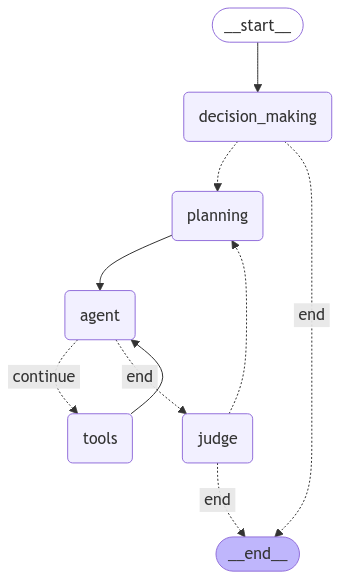

In [39]:
try:
    display(Image(app.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

## Example

In [64]:
async def print_stream(app: CompiledStateGraph, input: str) -> Optional[BaseMessage]:
    display(Markdown("## New research running"))
    display(Markdown(f"### Input:\n\n{input}\n\n"))
    display(Markdown("### Stream:\n\n"))

    # Stream the results
    all_messages = []
    async for chunk in app.astream({"messages": [input]}, stream_mode="updates"):
        print(chunk)
        for updates in chunk.values():
            if messages:= updates.get("messages"):
                all_messages.extend(messages)
                for message in messages:
                    message.pretty_print()
                    print("\n\n")
    # Return the last message if any
    if not all_messages:
        return None
    return all_messages[-1]


In [65]:
test_inputs = [
    "Download and summarize the findings of this paper: https://pmc.ncbi.nlm.nih.gov/articles/PMC11379842/pdf/11671_2024_Article_4070.pdf",

    "Can you find 8 papers on quantum machine learning?",
]
# Run tests and store the results for later visualisation
outputs = []
for test_input in test_inputs:
    final_answer = await print_stream(app, test_input)
    outputs.append(final_answer.content)

## New research running

### Input:

Download and summarize the findings of this paper: https://pmc.ncbi.nlm.nih.gov/articles/PMC11379842/pdf/11671_2024_Article_4070.pdf



### Stream:



required_search=True answer=None
{'decision_making': None}


AttributeError: 'NoneType' object has no attribute 'get'